pinhole Fresnel = 0.23163130884597868
detec Fresnel = 0.00023163130884597873
mario: (100, 100, 100) 2.0MB


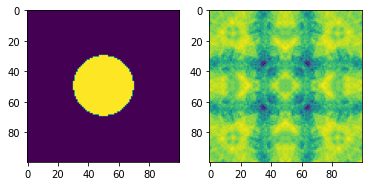

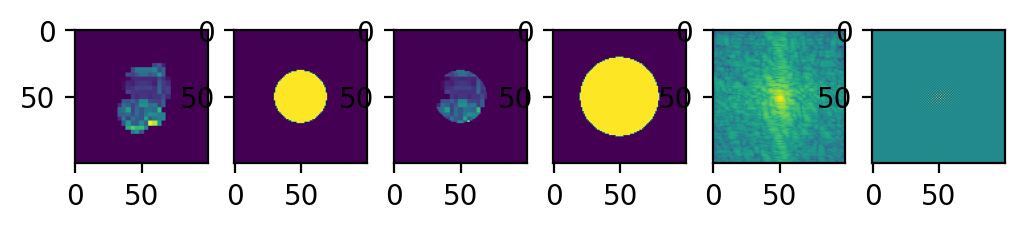

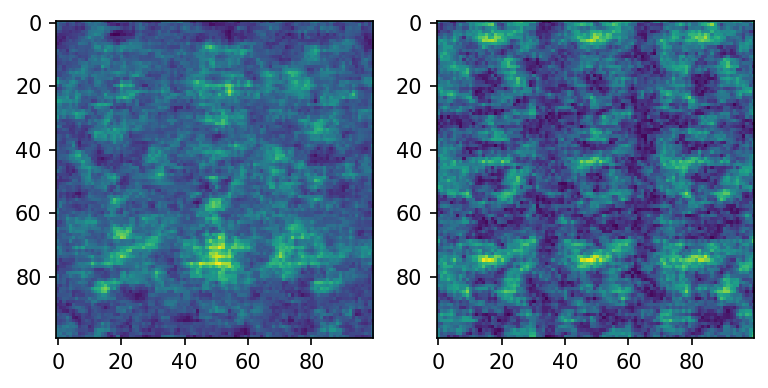

(None, None)

In [57]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cupy as cp

def propagate_beam(wavefront, dx, wavelength,distance,propagator='fourier'):
    """ Propagate a wavefront using fresnel ou fourier propagator

    Args:
        wavefront : the wavefront to propagate
        dx : pixel spacing of the wavefront input
        wavelength : wavelength of the illumination
        distance : distance to propagate
        propagator (str, optional): 'fresenel' or 'fourier'. Defaults to 'fresnel'.

    Returns:
        output: propagated wavefront
    """    
    from numpy.fft import fft2, fftshift, ifftshift, ifft2

    ysize, xsize = wavefront.shape
    
    x_array = np.linspace(-xsize/2,xsize/2-1,xsize)
    y_array = np.linspace(-ysize/2,ysize/2-1,ysize)
    
    fx = x_array/(xsize)
    fy = y_array/(ysize)
    
    FX,FY = np.meshgrid(fx,fy)

    if propagator == 'fourier':
        if distance > 0:
            output = fftshift(fft2(fftshift(wavefront)))
        else:
            output = ifftshift(ifft2(ifftshift(wavefront)))            
    elif propagator == 'fresnel':
        # % Calculate approx phase distribution for each plane wave component
        w = FX**2 + FY**2 
        # Compute FFT
        F = fftshift(fft2(fftshift(wavefront)))
        # % multiply by phase-shift and inverse transform 
        a = np.exp(-1j*np.pi*( distance*wavelength/dx**2)*w)
        output = ifftshift(ifft2(ifftshift(F*a)))

    return output

def PIE_update(params,difference,probe,obj,px,py,offset,algorithm="rPIE",update_obj,update_probe):
    """
     PIE: requires only regularization parameters
    ePIE: requires only step parameter
    rPIE: requires only regularization parameters. It is independent of the maximum probe value of the experiment. See https://doi.org/10.1364/OPTICA.4.000736
    mPIE: requires both step and regularization parameters
    """
    #TODO: update only where difpad is valid?
    #TODO: update probe using previous object instead of updated one?
    reg_obj,reg_probe,step_obj,step_probe,momentum_obj,momentum_probe,T_lim = params
    obj_section = obj[py:py+offset[0],px:px+offset[1]]
    if update_obj:
        if algorithm == "mPIE": # rPIE update function
            obj[py:py+offset[0],px:px+offset[1]] = obj_section + step_obj*difference*probe.conj()/ ( (1-reg_obj)*np.abs(probe)**2+reg_obj*(np.abs(probe)**2).max() )
        elif algorithm == "rPIE":
            obj[py:py+offset[0],px:px+offset[1]] = obj_section +         1*difference*probe.conj()/ ( (1-reg_obj)*np.abs(probe)**2+reg_obj*(np.abs(probe)**2).max() )
        elif algorithm == "ePIE": #ePIE update function
            obj[py:py+offset[0],px:px+offset[1]] = obj_section + step_obj*difference*probe.conj()/(np.abs(probe)**2).max()
        elif algorithm == "PIE":
            obj[py:py+offset[0],px:px+offset[1]] = obj_section + difference*probe.conj()*np.abs(probe)/((np.abs(probe).max()*(np.abs(probe)**2+reg_obj*(np.abs(probe)**2).max())))
        else: 
            sys.exit("Wrong algorithm. Select PIE, ePIE, rPIE or mPIE")
    if update_probe:
        if algorithm == "mPIE": # rPIE update function
            probe = probe + step_probe*difference*obj_section.conj()/ ( (1-reg_probe)*np.abs(obj_section)**2+reg_probe*(np.abs(obj_section)**2).max() )
        elif algorithm == "rPIE":
            probe = probe +          1*difference*obj_section.conj()/ ( (1-reg_probe)*np.abs(obj_section)**2+reg_probe*(np.abs(obj_section)**2).max() )
        elif algorithm == "ePIE": #ePIE update function
            probe = probe + step_probe*difference*obj_section.conj()/(np.abs(obj)**2).max()
        elif algorithm == "PIE":
            probe = probe +          1*difference*obj_section.conj()*np.abs(obj_section)/ ( (np.abs(obj_section).max()*np.abs(obj_section)**2+reg_probe*(np.abs(obj_section)**2).max())
        else: 
            sys.exit("Wrong algorithm. Select PIE, ePIE, rPIE or mPIE")        
    return obj, probe

def momentum_addition(T_counter,T_lim,probeVelocity,objVelocity,O_aux,P_aux,obj, probe,momentum_obj,momentum_probe):
    T_counter += 1 
    if T_counter == T_lim : # T parameter in mPIE paper
        probeVelocity  = probeVelocity*momentum_probe + (probe - P_aux)
        objVelocity = objVelocity*momentum_obj  + (obj - O_aux)  
        obj = O_aux + objVelocity
        probe = P_aux + probeVelocity 

        O_aux = obj
        P_aux = probe            
        T_counter = 0
        # T_counter = T_lim - 1
    return T_counter,objVelocity,probeVelocity,O_aux,P_aux,obj,probe

def get_object_pixel(N,pixel_size,wavelength,distance):
    return wavelength*distance/(N*pixel_size)

def magnitude_constraint(estimate,data):
    return np.sqrt(data)*estimate/np.abs(estimate)

def pinhole_constraint(wavefront,pinhole):
    wavefront[pinhole<=0] = 0
    wavefront[wavefront<0] = 0
    return wavefront

def support_constraint(wavefront,support,use_half_support=False):
    wavefront[support < 0] = 0
    return wavefront

def update_function(object,probe,wavefront,previous_wavefront,reg_obj,reg_probe):
    updated_object = object + reg_obj*np.conj(probe)*(wavefront-previous_wavefront)/np.abs(np.max(probe))**2
    updated_probe = probe + reg_probe*np.conj(object)*(wavefront-previous_wavefront)/np.abs(np.max(object))**2
    return updated_object, updated_probe

def mPIE_loop(difpads, positions,object_guess,probe_guess, mPIE_params,experiment_params, iterations):
    print("Starting PIE...")
    
    mPIE = True
    use_rPIE_update_function = True
    
    _,_,_,_,momentum_obj,momentum_probe,T_lim = mPIE_params
    
    offset = probe_guess.shape
    probeVelocity = 0
    objVelocity = 0
    T_counter = 0

    # difpads = np.asarray(difpads)
    # obj = np.asarray(object_guess)
    # probe = np.asarray(probe_guess)
    obj = object_guess
    probe = probe_guess
    
    print(type(obj),obj.shape)
    for j in range(iterations):

        if j%10 ==0 : print(f'\tIteration {j}/{iterations}')
        error, O_aux, P_aux = 0, obj+0, probe+0
        for i in np.random.permutation(len(difpads)):  
        # for i in range(len(difpads)):  
            px, py = positions[:,1][i],  positions[:,0][i]
            measurement = difpads[i]
            
            """ Exit wavefiled """
            exitWave = obj[py:py+offset[0],px:px+offset[1]]*probe

            """ Propagate + Update + Backpropagate """
            exitWaveNew = update_exit_wave(exitWave,measurement,experiment_params,epsilon=0.01)
            
            difference = exitWaveNew - exitWave
            
            obj, probe = PIE_update_obj_and_probe(mPIE_params,difference,probe,obj,px,py,offset,use_rPIE_update_function)
            
            if mPIE == True: # momentum addition
                T_counter,objVelocity,probeVelocity,O_aux,P_aux,obj,probe = momentum_addition(T_counter,T_lim,probeVelocity,objVelocity,O_aux,P_aux,obj, probe,momentum_obj,momentum_probe)

                
        # if j%2 == 0: # Print iteration
        #     figure, subplot = plt.subplots(1,2)
        #     subplot[0].imshow(np.abs(obj.get()),cmap=colormap)
        #     subplot[1].imshow(np.abs(probe.get()),cmap=colormap)
        #     subplot[0].set_title('Object')
        #     subplot[1].set_title('Probe')
        #     figure.suptitle(f'Iteration #{j}')
        #     plt.show()
        #     plt.close()

    # probe = probe.get() # get from cupy to numpy
    # obj = obj.get()

    return obj, probe

def get_error(wavefront,model):
    return np.sum(np.abs(wavefront-model))

speed_of_light, planck = 299792458, 4.135667662E-18  # Plank constant [keV*s]; Speed of Light [m/s]
N = 100

""" Load model """
model = np.ones((N,N))
calculate_error = True # flag to calculate error against model at each iteration
error = []


""" Input parameters """
distance = 10 # meters
energy = 3 # keV
wavelength = planck * speed_of_light / energy # meters
detector_pixel = 55e-6 # meters
n_of_pixels = 3072 
object_pixel_size = get_object_pixel(n_of_pixels,detector_pixel,wavelength,distance)
distance_pinhole = 10e-3 # m
phase_retrieval_iterations = 100
reg_obj,reg_probe = 0.5, 0.5# PIE update function parameters
apply_support = True

print(f'pinhole Fresnel = {(2*20*object_pixel_size)**2/(wavelength*distance_pinhole)}')
print(f'detec Fresnel = {(2*20*object_pixel_size)**2/(wavelength*distance)}')

""" Load measurement """
from sscPhantom import donuts, mario
phantom = mario.createMario(shape=N, noise=False, zoom=0.3)
phantom = np.sum(phantom,axis=1)


""" Pinhole """ 
import cv2
t = np.linspace(-phantom.shape[0]//2,phantom.shape[0]//2,phantom.shape[0])
x,y = np.meshgrid(t,t)
pinhole = np.where((x)**2 + (y)**2 < 20**2,1,0)

probe = propagate_beam(pinhole,object_pixel_size,wavelength,distance_pinhole,propagator='fresnel')

figure, ax = plt.subplots(1,2)
ax1,ax2 = ax.ravel()
ax1.imshow(pinhole)
ax2.imshow(np.abs(probe),norm=LogNorm())
plt.show(),plt.close()

wavefront = phantom*probe
DP = np.abs( np.fft.fftshift( np.fft.fft2(wavefront) ) )**2

""" Initial guess """
probe = propagate_beam(pinhole,object_pixel_size,wavelength,distance_pinhole,propagator='fresnel')
object = np.ones_like(probe,dtype=complex)
wavefront = probe*object


""" Estimate support from auto-correlation """
autocorr = np.fft.fftshift( np.fft.ifft2( DP ).real )
support = np.where((x)**2 + (y)**2 < 30**2,1,0)


figure, ax = plt.subplots(1,6,dpi=200)
ax1,ax2,ax3,ax4,ax5,ax6 = ax.ravel()
ax1.imshow(phantom)
ax2.imshow(pinhole)
ax3.imshow(phantom*pinhole)
ax4.imshow(support)
ax5.imshow(DP,norm=LogNorm())
ax6.imshow(autocorr)

""" Phase-retrieval loop """
for iter in range(0,phase_retrieval_iterations):

    previous_wavefront = wavefront
    """ Fourier Space-constraint """
    wavefront = propagate_beam(wavefront, object_pixel_size, wavelength,+distance) # propagate
    wavefront = magnitude_constraint(wavefront,DP) # substitute known magnitude
    wavefront = propagate_beam(wavefront, object_pixel_size, wavelength,-distance) # backpropagate

    """ Real Space-constraint """
    if apply_support == True:
        wavefront = support_constraint(wavefront,support)

    probe = wavefront/object

    object, probe = update_function(object,probe,wavefront,previous_wavefront,reg_obj,reg_probe) # update function of the PIE family

    probe = propagate_beam(probe,object_pixel_size,wavelength,-distance_pinhole,propagator='fresnel') # short distance propagation! is fresnel propagator the correct one?
    probe = pinhole_constraint(probe,pinhole) # set wavefront null outside pinhole; set negative values null inside pinhole
    probe = propagate_beam(probe,object_pixel_size,wavelength,+distance_pinhole,propagator='fresnel')

    wavefront = probe*object

    if calculate_error:
        error.append(get_error(wavefront,phantom))


figure, ax = plt.subplots(1,2,dpi=150)
ax2,ax3 = ax.ravel()
# ax1.plot(error)
ax2.imshow(np.abs(object))
ax3.imshow(np.abs(probe))
# ax1.set_xlabel('Iterations'), ax1.set_ylabel('Error')
plt.show(), plt.close()